# Is social sentiment statistically associated with stock price volatility?

Author: Ashvanth Rathinavel

In [4]:
import numpy as np
import pandas as pd
import os 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

## Data Preprocessing and Merging

In [6]:
# Set the data directory path
data_dir = "dataset/combined_data"

# Load datasets
market_data = pd.read_csv(os.path.join(data_dir, "combined_market_data_clean.csv"))
news_data = pd.read_csv(os.path.join(data_dir, "combined_news_data_clean.csv"))
reddit_data = pd.read_csv(os.path.join(data_dir, "combined_reddit_data_clean.csv"))

# Basic info for shape and null checks
print("Market Data Shape:", market_data.shape)
print("News Data Shape:", news_data.shape)
print("Reddit Data Shape:", reddit_data.shape)

print("\nMissing Values:\n")
print("Market Data:\n", market_data.isnull().sum())
print("News Data:\n", news_data.isnull().sum())
print("Reddit Data:\n", reddit_data.isnull().sum())

Market Data Shape: (279, 7)
News Data Shape: (900, 4)
Reddit Data Shape: (1261, 6)

Missing Values:

Market Data:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
ticker    0
dtype: int64
News Data:
 date      0
title     0
url       0
ticker    0
dtype: int64
Reddit Data:
 subreddit    0
title        0
score        0
created      0
url          0
ticker       0
dtype: int64


In [7]:
# Rename to lowercase
market_data.rename(columns={'Date': 'date'}, inplace=True)

# Parse with utc=True, coercing errors
market_data['date'] = pd.to_datetime(market_data['date'], errors='coerce', utc=True)

# Drop any rows that failed to parse
market_data = market_data.dropna(subset=['date'])

# Extract just the date (this yields Python date objects)
market_data['date'] = market_data['date'].dt.date

reddit_data['date'] = pd.to_datetime(reddit_data['created'], errors='coerce')
reddit_data['date'] = reddit_data['date'].dt.date

news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce')
news_data = news_data.dropna(subset=['date'])  # drop rows with invalid dates
news_data['date'] = news_data['date'].dt.date

In [8]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Function to get compound sentiment score
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return analyzer.polarity_scores(text)['compound']

In [9]:
# Apply to news titles
news_data['sentiment_score'] = news_data['title'].apply(get_sentiment)

# Apply to Reddit titles
reddit_data['sentiment_score'] = reddit_data['title'].apply(get_sentiment)

# News sentiment: daily average per stock
news_daily = news_data.groupby(['date', 'ticker'])['sentiment_score'].mean().reset_index()
news_daily.rename(columns={'sentiment_score': 'news_sentiment'}, inplace=True)

# Reddit sentiment: daily average per stock
reddit_daily = reddit_data.groupby(['date', 'ticker'])['sentiment_score'].mean().reset_index()
reddit_daily.rename(columns={'sentiment_score': 'reddit_sentiment'}, inplace=True)

# Compute daily log returns per ticker
market_data['log_return'] = market_data.groupby('ticker')['Close'].transform(lambda x: np.log(x / x.shift(1)))

# Compute 5-day rolling standard deviation (volatility)
market_data['volatility'] = market_data.groupby('ticker')['log_return'].transform(lambda x: x.rolling(window=5).std())

# Drop intermediate column if not needed
market_data.drop(columns=['log_return'], inplace=True)  
# Fill NaN volatility values with the per-ticker mean
market_data['volatility'] = market_data.groupby('ticker')['volatility'].transform(lambda x: x.fillna(x.mean()))

In [10]:
# Compute day-over-day change in sentiment for news and reddit
news_daily['news_sentiment_change'] = news_daily.groupby('ticker')['news_sentiment'].diff()
reddit_daily['reddit_sentiment_change'] = reddit_daily.groupby('ticker')['reddit_sentiment'].diff()

# Count number of headlines per (date, ticker)
news_volume = news_data.groupby(['date', 'ticker']).size().reset_index(name='news_volume')

# Count number of reddit posts per (date, ticker)
reddit_volume = reddit_data.groupby(['date', 'ticker']).size().reset_index(name='reddit_volume')

# Merge volume into sentiment daily aggregates
news_daily = pd.merge(news_daily, news_volume, on=['date', 'ticker'], how='left')
reddit_daily = pd.merge(reddit_daily, reddit_volume, on=['date', 'ticker'], how='left')

In [11]:
# Merge market with news sentiment
merged = pd.merge(market_data, news_daily, on=['date', 'ticker'], how='left')

# Merge with reddit sentiment
merged = pd.merge(merged, reddit_daily, on=['date', 'ticker'], how='left')

# Fill NaNs ticker-wise 
merged['news_sentiment'] = merged.groupby('ticker')['news_sentiment'].transform(lambda x: x.fillna(x.mean()))
merged['reddit_sentiment'] = merged.groupby('ticker')['reddit_sentiment'].transform(lambda x: x.fillna(x.mean()))

# Ensure 'date' is properly parsed
merged['date'] = pd.to_datetime(merged['date'], errors='coerce').dt.date

# Drop rows where date couldn't be parsed
merged = merged.dropna(subset=['date'])

# Impute sentiment change and volume features with 0
merged['news_sentiment_change'] = merged['news_sentiment_change'].fillna(0)
merged['news_volume'] = merged['news_volume'].fillna(0)

merged['reddit_sentiment_change'] = merged['reddit_sentiment_change'].fillna(0)
merged['reddit_volume'] = merged['reddit_volume'].fillna(0)

print(merged.head())
merged.to_csv("merged_sentiment_volatility.csv", index=False)

         date        Open        High         Low       Close    Volume  \
0  2025-03-03  241.789993  244.029999  236.110001  238.029999  47184000   
1  2025-03-04  237.710007  240.070007  234.679993  235.929993  53798100   
2  2025-03-05  235.419998  236.550003  229.229996  235.740005  47227600   
3  2025-03-06  234.440002  237.860001  233.160004  235.330002  45170400   
4  2025-03-07  235.110001  241.369995  234.759995  239.070007  46273600   

  ticker  volatility  news_sentiment  news_sentiment_change  news_volume  \
0   AAPL    0.032884        0.000000               0.000000          1.0   
1   AAPL    0.032884        0.146750               0.146750          2.0   
2   AAPL    0.032884        0.158467               0.011717          3.0   
3   AAPL    0.032884        0.063190               0.000000          0.0   
4   AAPL    0.032884        0.063190               0.000000          0.0   

   reddit_sentiment  reddit_sentiment_change  reddit_volume  
0          -0.17350           

## Data Analysis

### Same-Day, Lead, and Lagged Correlation

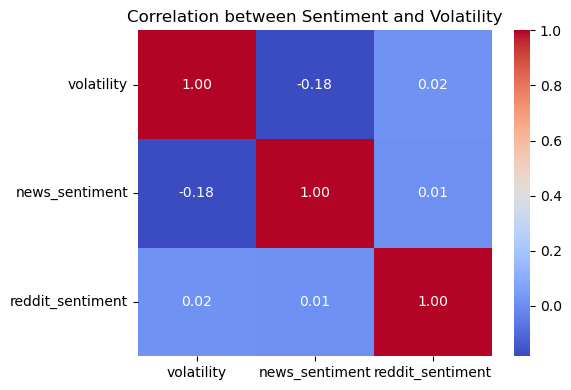

In [14]:
corr_same_day = merged[['volatility', 'news_sentiment', 'reddit_sentiment']].corr()
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_same_day, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Sentiment and Volatility")
plt.tight_layout()
plt.show()

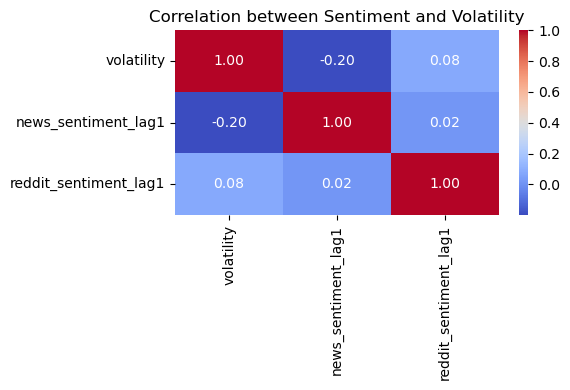

In [15]:
merged['news_sentiment_lag1'] = merged.groupby('ticker')['news_sentiment'].shift(1)
merged['reddit_sentiment_lag1'] = merged.groupby('ticker')['reddit_sentiment'].shift(1)

corr_sent_lag = merged[['volatility', 'news_sentiment_lag1', 'reddit_sentiment_lag1']].corr()
# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_sent_lag, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Sentiment and Volatility")
plt.tight_layout()
plt.show()

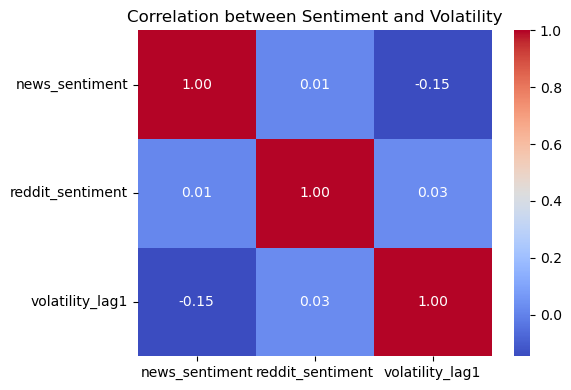

In [16]:
merged['volatility_lag1'] = merged.groupby('ticker')['volatility'].shift(1)

corr_sent_lead = merged[['news_sentiment', 'reddit_sentiment', 'volatility_lag1']].corr()

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_sent_lead, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Sentiment and Volatility")
plt.tight_layout()
plt.show()

### Sentiment and Volume vs. Volatility

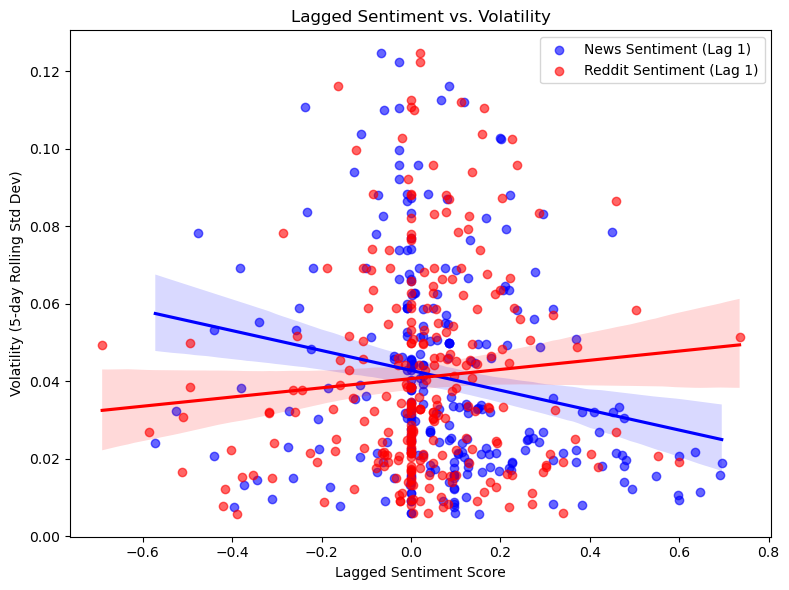

In [18]:
# Set up the figure
plt.figure(figsize=(8, 6))

# Plot news sentiment lag vs volatility
sns.regplot(
    data=merged,
    x='news_sentiment_lag1',
    y='volatility',
    scatter_kws={'alpha': 0.6},
    label='News Sentiment (Lag 1)',
    color='blue'
)

# Plot reddit sentiment lag vs volatility
sns.regplot(
    data=merged,
    x='reddit_sentiment_lag1',
    y='volatility',
    scatter_kws={'alpha': 0.6},
    label='Reddit Sentiment (Lag 1)',
    color='red'
)

plt.title("Lagged Sentiment vs. Volatility")
plt.xlabel("Lagged Sentiment Score")
plt.ylabel("Volatility (5-day Rolling Std Dev)")
plt.legend()
plt.tight_layout()
plt.show()

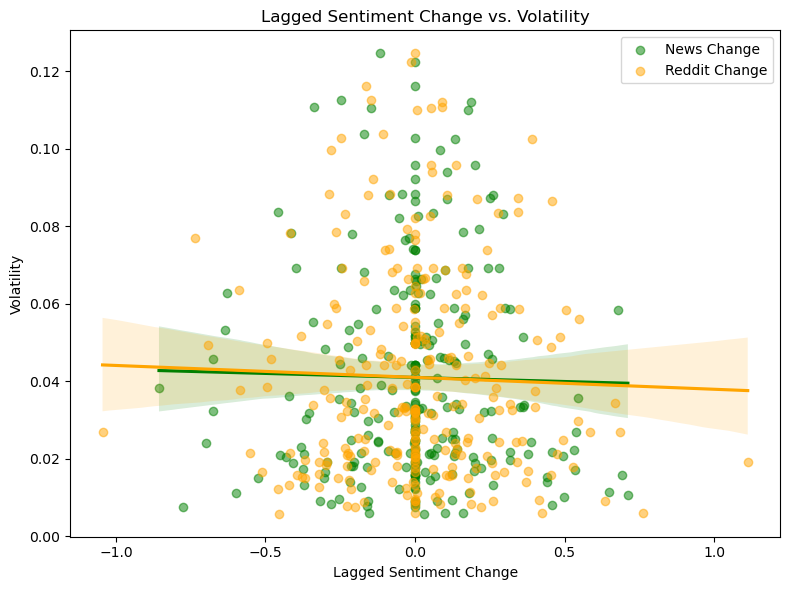

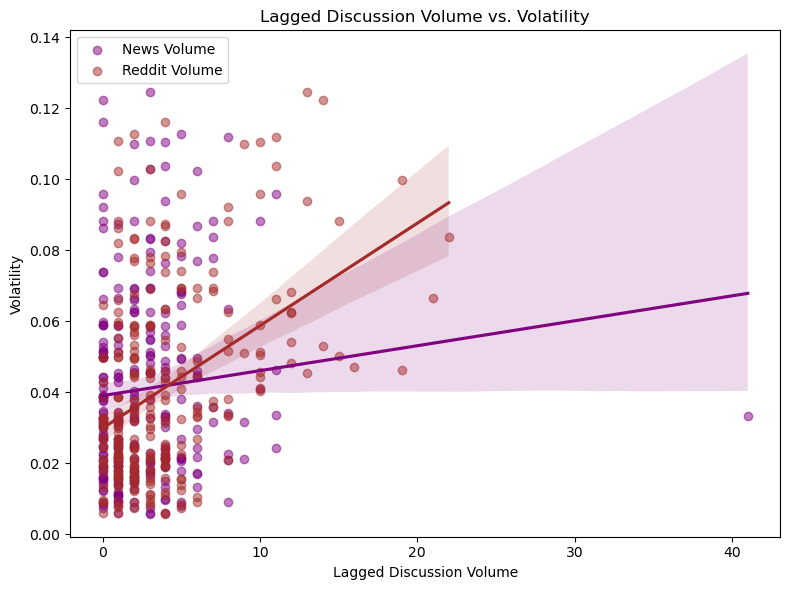

In [19]:
# Shift features by 1 day to make them lagged
merged['news_sentiment_change_lag1'] = merged.groupby('ticker')['news_sentiment_change'].shift(1)
merged['reddit_sentiment_change_lag1'] = merged.groupby('ticker')['reddit_sentiment_change'].shift(1)
merged['news_volume_lag1'] = merged.groupby('ticker')['news_volume'].shift(1)
merged['reddit_volume_lag1'] = merged.groupby('ticker')['reddit_volume'].shift(1)

# Sentiment Change (Lagged) vs Volatility
plt.figure(figsize=(8, 6))
sns.regplot(data=merged, x='news_sentiment_change_lag1', y='volatility', label='News Change', color='green', scatter_kws={'alpha':0.5})
sns.regplot(data=merged, x='reddit_sentiment_change_lag1', y='volatility', label='Reddit Change', color='orange', scatter_kws={'alpha':0.5})
plt.title("Lagged Sentiment Change vs. Volatility")
plt.xlabel("Lagged Sentiment Change")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

# Volume (Lagged) vs Volatility
plt.figure(figsize=(8, 6))
sns.regplot(data=merged, x='news_volume_lag1', y='volatility', label='News Volume', color='purple', scatter_kws={'alpha':0.5})
sns.regplot(data=merged, x='reddit_volume_lag1', y='volatility', label='Reddit Volume', color='brown', scatter_kws={'alpha':0.5})
plt.title("Lagged Discussion Volume vs. Volatility")
plt.xlabel("Lagged Discussion Volume")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

### Sentiment Features Correlations

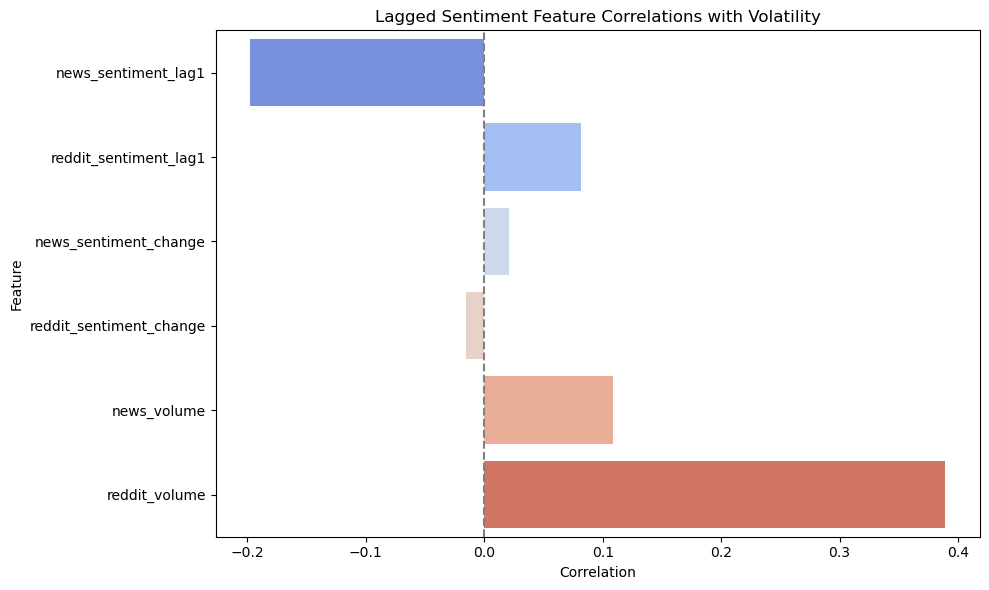

In [21]:
# Define lagged features
lagged_features = [
    'news_sentiment_lag1',
    'reddit_sentiment_lag1',
    'news_sentiment_change',
    'reddit_sentiment_change',
    'news_volume',
    'reddit_volume'
]

# Compute correlations with volatility
correlations = [merged['volatility'].corr(merged[feature]) for feature in lagged_features]

# Create DataFrame for plotting
corr_df = pd.DataFrame({
    'Feature': lagged_features,
    'Correlation': correlations
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, y='Feature', x='Correlation', hue='Feature', palette='coolwarm', dodge=False, legend=False)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Lagged Sentiment Feature Correlations with Volatility')
plt.tight_layout()
plt.show()

### Stock-Wise Effects

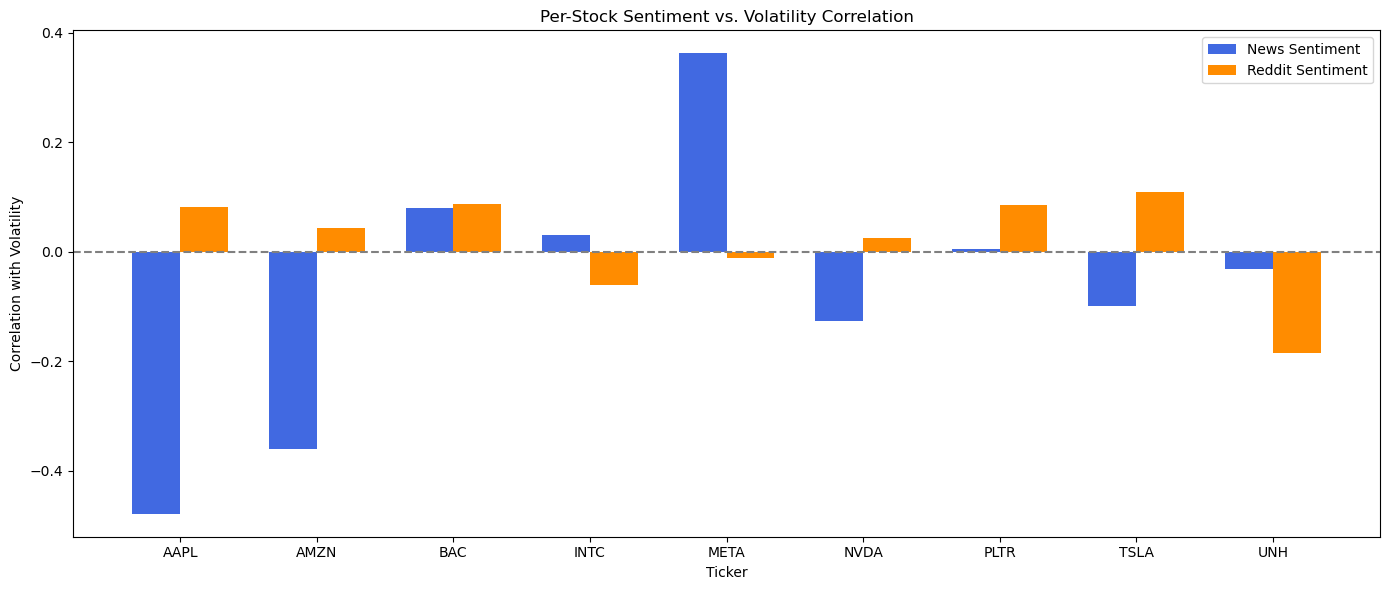

In [23]:
# Compute per-ticker correlations
corr_df = (
    merged.groupby('ticker')[['volatility', 'news_sentiment_lag1', 'reddit_sentiment_lag1']]
    .corr()
    .unstack()
    .loc[:, ('volatility', ['news_sentiment_lag1', 'reddit_sentiment_lag1'])]
)

# Rename columns for clarity
corr_df.columns = ['news_sentiment_corr', 'reddit_sentiment_corr']

# Extract values for plotting
tickers = list(corr_df.index)
news_corrs = corr_df['news_sentiment_corr'].values
reddit_corrs = corr_df['reddit_sentiment_corr'].values

# Bar chart
x = np.arange(len(tickers))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, news_corrs, width, label='News Sentiment', color='royalblue')
plt.bar(x + width/2, reddit_corrs, width, label='Reddit Sentiment', color='darkorange')

plt.xticks(x, tickers)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Ticker')
plt.ylabel('Correlation with Volatility')
plt.title('Per-Stock Sentiment vs. Volatility Correlation')
plt.legend()
plt.tight_layout()
plt.show()

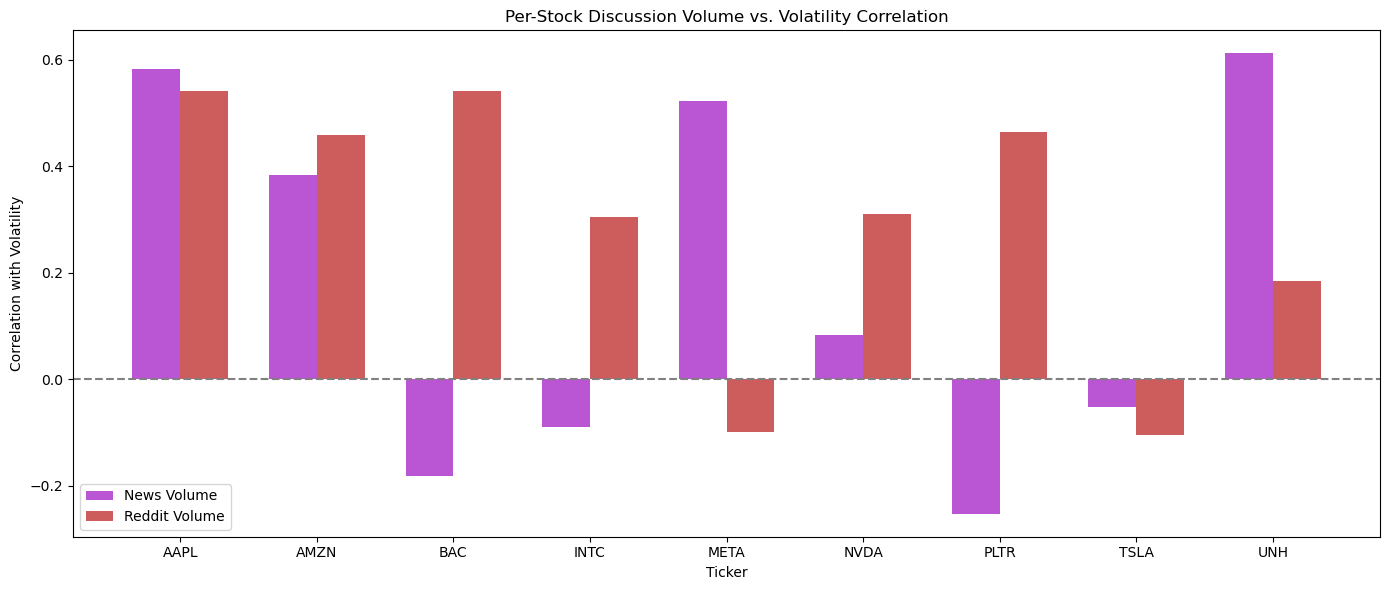

In [24]:
# Compute correlation matrix for each ticker group
volume_corrs = {}
tickers = merged['ticker'].unique()

for ticker in tickers:
    df_ticker = merged[merged['ticker'] == ticker]
    corr = df_ticker[['news_volume', 'reddit_volume', 'volatility']].corr()
    volume_corrs[ticker] = {
        'news_volume': corr.loc['volatility', 'news_volume'],
        'reddit_volume': corr.loc['volatility', 'reddit_volume']
    }

# Convert to DataFrame
volume_corrs_df = pd.DataFrame(volume_corrs).T  # T to flip to ticker rows
volume_corrs_df = volume_corrs_df.sort_index()

# Plot
x = np.arange(len(volume_corrs_df))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, volume_corrs_df['news_volume'], width, label='News Volume', color='mediumorchid')
plt.bar(x + width/2, volume_corrs_df['reddit_volume'], width, label='Reddit Volume', color='indianred')

plt.xticks(x, volume_corrs_df.index)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Ticker')
plt.ylabel('Correlation with Volatility')
plt.title('Per-Stock Discussion Volume vs. Volatility Correlation')
plt.legend()
plt.tight_layout()
plt.show()

## Regression Modeling

In [26]:
# Ensure 'date' is datetime
merged['date'] = pd.to_datetime(merged['date'])

# Filter for March 2025
merged_march = merged[(merged['date'].dt.month == 3) & (merged['date'].dt.year == 2025)].copy()

In [27]:
# Recreate lag features and normalization 
merged_march['news_sentiment_lag1'] = merged_march.groupby('ticker')['news_sentiment'].shift(1)
merged_march['reddit_sentiment_lag1'] = merged_march.groupby('ticker')['reddit_sentiment'].shift(1)
merged_march['news_sentiment_change_lag1'] = merged_march.groupby('ticker')['news_sentiment_change'].shift(1)
merged_march['reddit_sentiment_change_lag1'] = merged_march.groupby('ticker')['reddit_sentiment_change'].shift(1)
merged_march['news_volume_lag1'] = merged_march.groupby('ticker')['news_volume'].shift(1)
merged_march['reddit_volume_lag1'] = merged_march.groupby('ticker')['reddit_volume'].shift(1)
merged_march['volatility_lag1'] = merged_march.groupby('ticker')['volatility'].shift(1)

# Z-score normalization for volume
merged_march['news_volume_lag1_z'] = merged_march.groupby('ticker')['news_volume_lag1'].transform(lambda x: (x - x.mean()) / x.std())
merged_march['reddit_volume_lag1_z'] = merged_march.groupby('ticker')['reddit_volume_lag1'].transform(lambda x: (x - x.mean()) / x.std())

### Without Lagged Volatility

Train RMSE: 0.0180
Test RMSE: 0.0259
Train R² score: 0.1021
Test R² score: 0.0256
Optimal alpha: 100.0

Ridge Regression Coefficients:
                   Feature  Coefficient
0      news_sentiment_lag1    -0.003418
1    reddit_sentiment_lag1     0.000647
2    news_sentiment_change    -0.000958
3  reddit_sentiment_change     0.000121
4       news_volume_lag1_z    -0.000956
5     reddit_volume_lag1_z    -0.001410


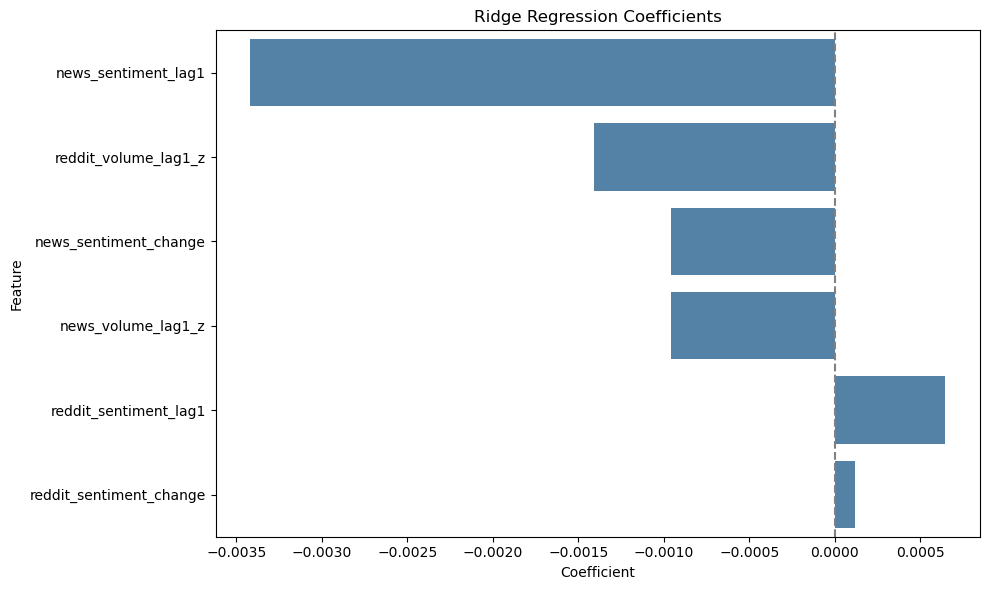

In [29]:
# Define features
features = [
    'news_sentiment_lag1',
    'reddit_sentiment_lag1',
    'news_sentiment_change',
    'reddit_sentiment_change',
    'news_volume_lag1_z',
    'reddit_volume_lag1_z',

]
target = 'volatility'

# Drop NaNs and retain date for plotting
model_data = merged_march.dropna(subset=features + [target]).copy()
model_data['date'] = merged_march.loc[model_data.index, 'date']

# Extract X and y
X = model_data[features]
y = model_data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression with cross-validated alpha
alphas = [0.01, 0.1, 1, 10, 100, 1000]
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

# Evaluation
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Manually compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Train R² score: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R² score: {r2_score(y_test, y_pred_test):.4f}")
print(f"Optimal alpha: {ridge.alpha_}")

# Coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': ridge.coef_})
print("\nRidge Regression Coefficients:")
print(coef_df)

# Create a dataframe of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', color='steelblue')
plt.title('Ridge Regression Coefficients')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

### With Lagged Volatility

Train RMSE: 0.0090
Test RMSE: 0.0079
Train R² score: 0.7724
Test R² score: 0.9088
Optimal alpha: 1.0

Ridge Regression Coefficients:
                   Feature  Coefficient
0      news_sentiment_lag1    -0.000627
1    reddit_sentiment_lag1     0.001114
2    news_sentiment_change    -0.000678
3  reddit_sentiment_change     0.000279
4       news_volume_lag1_z     0.000934
5     reddit_volume_lag1_z    -0.001242
6          volatility_lag1     0.017782


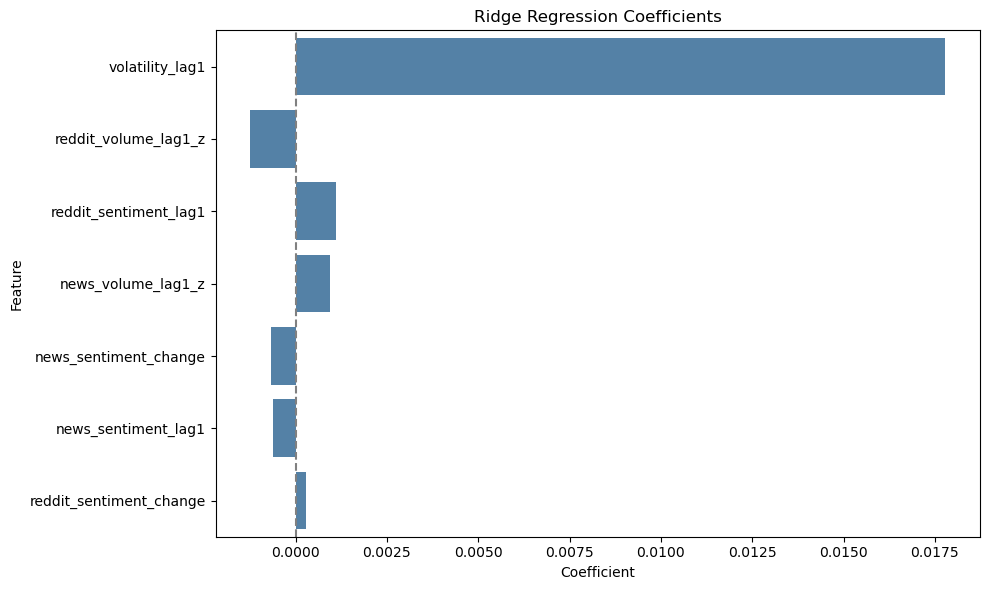

In [31]:
# Define features
features = [
    'news_sentiment_lag1',
    'reddit_sentiment_lag1',
    'news_sentiment_change',
    'reddit_sentiment_change',
    'news_volume_lag1_z',
    'reddit_volume_lag1_z',
    'volatility_lag1'
]
target = 'volatility'

# Drop NaNs and retain date for plotting
model_data = merged_march.dropna(subset=features + [target]).copy()
model_data['date'] = merged_march.loc[model_data.index, 'date']

# Extract X and y
X = model_data[features]
y = model_data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ridge Regression with cross-validated alpha
alphas = [0.01, 0.1, 1, 10, 100, 1000]
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

# Evaluation
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Manually compute RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE: {rmse_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Train R² score: {r2_score(y_train, y_pred_train):.4f}")
print(f"Test R² score: {r2_score(y_test, y_pred_test):.4f}")
print(f"Optimal alpha: {ridge.alpha_}")

# Coefficients
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': ridge.coef_})
print("\nRidge Regression Coefficients:")
print(coef_df)

# Create a dataframe of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', color='steelblue')
plt.title('Ridge Regression Coefficients')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

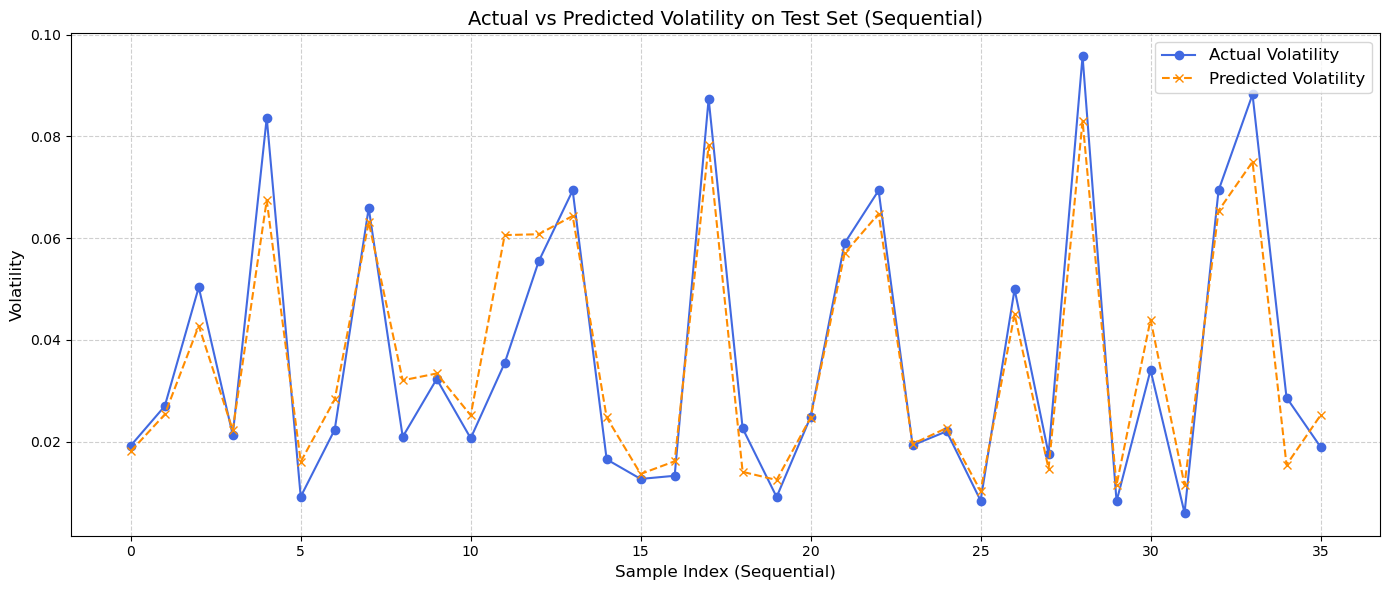

In [32]:
plt.figure(figsize=(14, 6))

# Sequential plot (not by date)
plt.plot(y_test.values, label='Actual Volatility', color='royalblue', marker='o', linewidth=1.5)
plt.plot(y_pred_test, label='Predicted Volatility', color='darkorange', linestyle='--', marker='x', linewidth=1.5)

# Formatting
plt.xlabel('Sample Index (Sequential)', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.title('Actual vs Predicted Volatility on Test Set (Sequential)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()